In [1]:
import numpy as np
import scipy
import sklearn
import sklearn.datasets
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### helper functions ###

# activation function g
# activation A = g(Z) 
def calc_gZ(Z, g='logistic'):
    
    gZ = np.zeros((Z.shape[0], Z.shape[1]))
    
    # check if g is 'logistic'
    if g == 'logistic':
        gZ = scipy.special.expit(Z) 
    # else if g is 'relu'
    # set appropriate gZ for relu activation
    elif g == 'relu':
        gZ = np.maximum(0,Z)
    
    return gZ

# dg(Z)/dZ
def calc_dgZ_dZ(gZ, Z, g='logistic'):
    
    dgZ_dZ = np.zeros((Z.shape[0], Z.shape[1]))
    
    # check if g is 'logistic'
    if g == 'logistic':
        dgZ_dZ = gZ*(1-gZ)
    # else if g is 'relu'
    # set appropriate dgZ_dZ for relu activation
    elif g == 'relu':
        dgZ_dZ = (Z > 0).astype(int)
        
    return dgZ_dZ

# cost  J
# note: asumming binary classification (logloss)
def calc_J(AL, Y):
     
    m = Y.shape[0] 
    
    # average log-loss 
    eps=1e-8
    clippedAL = np.maximum(eps, np.minimum(1 - eps, AL))
    J = (-1./m) * (np.dot(Y.T,np.log(clippedAL)) + np.dot(1-Y.T, np.log(1-clippedAL)))
    
    J = np.squeeze(J)
    
    return J

# for the output layer:
# for certain combinations of activation+loss (logistic+logloss, linear+mse, softmax+crossentropy),
# it's typically more efficient to directly compute and use dJ/dZ=AL-Y,
# rather than computing dJ/dZ = dJ/dA * dA/dZ 
# note: asumming binary classification (logistic+logloss)
def calc_dJ_dZ(AL, Y):
    
    # logistic activation and avg log-loss 
    dJ_dZ = AL - Y
    
    return dJ_dZ

# intialize Weights as per activation function
def init_W(nprev, n, g='logistic'):
    
    W = np.zeros((nprev, n))
    
    # check if g is 'logistic' or 'tanh', set W to Xavier initialization
    # else if g is 'relu', set W to Kaiming initialization
    # else, set W to np.random.randn(nprev, n)
    if g == 'logistic' or g =='tanh':
        W = np.random.randn(nprev,n)*np.sqrt(1/nprev)
    elif g == 'relu':
        W = np.random.randn(nprev,n)*np.sqrt(2/nprev)
    else:
        W = np.random.randn(nprev, n)
    
    return W

In [3]:
### fully-connected layer class ###

class FullyConnectedLayer:
    
    # activation function g can be 'logistic' or 'relu' - defaults to 'logistic'
    def __init__(self, nprev, n, g='logistic'):
        
        # number of nodes in this layer
        self.n = n                   
        
        # number of nodes in previous layer
        self.nprev = nprev    
        
        # activation function for this layer
        self.g = g
        
        # initialize weights for this layer
        self.W = init_W(self.nprev, self.n, self.g) 
        
        # initialize bias for this layer
        self.b = np.zeros((1, self.n))       
        
        # these will get set in the forward method
        self.Aprev = None
        self.Z = None
        self.A = None
        
        # these will get set in the backward method
        self.dJ_dW = None
        self.dJ_db = None
    
    
    # forward pass for layer
    def forward(self, Aprev):
        
        self.Aprev = Aprev
        self.Z =  np.dot(self.Aprev, self.W) + self.b 
        self.A = calc_gZ(self.Z, self.g) # A = g(Z)
        
        return self.A

    
    # backward propagation for hidden layer
    # here we first compute dgZ_dZ, and then compute dJ_dZ = dJ_dA * dgZ_dZ
    def backward_hidden_layer(self, dJ_dA):
        
        m = self.A.shape[0] 
        
        dgZ_dZ = calc_dgZ_dZ(self.A, self.Z, self.g) # A = g(Z)
        dJ_dZ = np.multiply(dJ_dA, dgZ_dZ) # dJ/dZ = dJ/dA * dA/dZ = dJ/dA * dg(Z)/dZ
        self.dJ_dW = (1./m)*np.dot(self.Aprev.T, dJ_dZ)  # dJ/dW = dJ/dZ * dZ/dW  
        self.dJ_db = (1./m)*np.sum(dJ_dZ, axis=0, keepdims=True) # dJ/db = dJ/dZ * dZ/db 
        dJ_dAprev = np.dot(dJ_dZ, self.W.T) # dJ/dAprev = dJ/dZ * dZ/dAprev 
        
        return dJ_dAprev
    
    
    # backward propagation for output layer
    # here we directly compute dJ_dZ 
    def backward_output_layer(self, Y):
        
        m = self.A.shape[0] 
            
        dJ_dZ = calc_dJ_dZ(self.A, Y)
        self.dJ_dW = (1./m)*np.dot(self.Aprev.T, dJ_dZ)  # dJ/dW = dJ/dZ * dZ/dW  
        self.dJ_db = (1./m)*np.sum(dJ_dZ, axis=0, keepdims=True) # dJ/db = dJ/dZ * dZ/db 
        dJ_dAprev = np.dot(dJ_dZ, self.W.T) # dJ/dAprev = dJ/dZ * dZ/dAprev 
        
        return dJ_dAprev
    
    
    # gradient descent for layer
    def optimize(self, alpha):
        
        self.W = self.W - alpha*self.dJ_dW
        self.b = self.b - alpha*self.dJ_db
        

In [4]:
### fully connected network class ###
### this class must use the FullyConnectedLayer class to build the network ###

class FullyConnectedNetwork:
    
    # n0 is is the "number of nodes" (which is just number of features n) in input layer
    # nH is the number of nodes in each hidden layer (for instance nH=(15,5) implies two hidden layers with 15 and 5 nodes) 
    # nL is the number of nodes in the output layer
    # hidden_g can be 'logistic' or 'relu', output_g can be 'logistic'
    def __init__(self, n0=0, nH=(), nL=0, hidden_g='logistic', output_g='logistic'):
        
        # number of nodes in each layer in network 
        # (input layer size, followed by hidden layer sizes, followed by output layer size)
        self.layer_sizes = [n0, *nH, nL]   
        
        # number of layers in network
        self.L = len(self.layer_sizes) - 1  
        
        # create the network as a list of FullyConnectedLayer objects
        self.layers = []
        
        # input layer is a dummy layer
        self.layers.append(None)
        
        # create hidden layers 1 through L-1 based on nH and hidden_g
        for i in range(1,self.L):
            i = FullyConnectedLayer(nprev = self.layer_sizes[i-1], n = self.layer_sizes[i], g = hidden_g)
            self.layers.append(i)
                            
            
        
        # create output layer L based on nL and output_g
        output = FullyConnectedLayer(nprev = nH[-1], n = nL, g = output_g)
        self.layers.append(output)
        
    
    # forward pass for network
    def forward_pass(self, Aprev):
        
        # forward pass Aprev from layer 1 through layer L 
        # note: A from each layer will become Aprev to the next layer
        self.Aprev = Aprev
        for i in range(1, self.L+1):
            self.A = self.layers[i].forward(Aprev = self.Aprev)
            self.Aprev = self.A
            A = self.A
        # return A (that comes out of output layer)
        return A
        
    
    # backward propagation for network
    def backward_propagation (self, Y): 
        
        # use backward_output_layer to backprop through output layer L
        # note: the dJ_dAprev from each layer will become the dJ_dA to the previous layer
        self.Y = Y
        dj_dA_Output = self.layers[-1].backward_output_layer(self.Y)
            
        # use backward_hidden_layer to backprop through hidden layers L-1,...,2,1
        # note: the dJ_dAprev from each layer will become the dJ_dA to the previous layer
        self.dJ_dA = dj_dA_Output
        for i in range(self.L-1, 0, -1):
            dJ_dAprev = self.layers[i].backward_hidden_layer(dJ_dA = self.dJ_dA)
            self.dJ_dA = dJ_dAprev
            
    
    
    # gradient descent for network
    def gradient_descent (self, alpha):
        
        # use optimize to update parameters for layers 1,2,...,L
        self.alpha = alpha
        for i in range(1, self.L+1):
            self.layers[i].optimize(alpha = self.alpha)

            
    # fit the dnn model to the data
    def fit (self, X, Y, alpha=0.0075, nepochs=3000):
        
        costs = []
        
        for i in range(nepochs):
            
            # forward pass and calculate current loss
            AL = self.forward_pass(X)
            J = calc_J(AL, Y)
            
            # backward propagation (calculate current gradients)
            self.backward_propagation(Y) 
            
            # gradient descent (update parameters)
            self.gradient_descent(alpha)
            
            # append caculated loss to costs
            costs.append(J)
        
        # plot costs versus iterations; print alpha and final cost in plot title
        plt.plot(np.squeeze(costs))
        plt.xlabel('Iterations')
        plt.ylabel('Costs')
        plt.title('Cost: '+ str(np.round_(costs[-1], 3)) + ' Alpha: ' + str(alpha))
        plt.show()
    
    
    # make predictions for given input X (this can be train or test data)
    # note: assuming binary classification 
    def predict (self, X):
        
        # given input, predict output and assign to variable Ypred
        Ypred = self.forward_pass(X)
        # return the calculated Ypred
        return Ypred
    
    
    # calculate accuracy of prediction by comparing to target data
    # note: assuming binary classification
    def accuracy(self, Ypred, Y):
        
        # given predictions and targets, calculate accuracy score and assign to variable score
        Ypred_round = np.round_(Ypred)
        correct = 0
        for i in range(len(Y)):
            if Y[i] == Ypred_round[i]:
                correct += 1
        score = correct / float(len(Y)) * 100.0
        # return the calculated score
        return score
    

In [5]:
# let's use the breast cancer dataset from sklearn
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()
features = dataset.feature_names
X = dataset.data
Y = dataset.target
Y = Y.reshape(Y.shape[0], 1)
m = X.shape[0]
n = X.shape[1]

print (m, n)

569 30


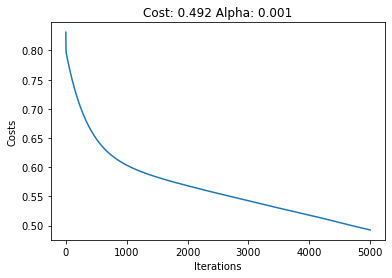

91.74


In [6]:
# test number 1: 
# - nepochs=5000; alpha=0.001; nH=(15,); hidden_g='logistic'
# - this gives an accuracy of 0.92
# - with slow convergence (# of iternations to hit minimum cost) and final cost of 0.49

np.random.seed(42) 
nepochs = 5000 # number of epochs
alpha = 0.001 # learning rate

fcn = FullyConnectedNetwork(
    n0=n, nH=(15,), nL=1, 
    hidden_g='logistic', output_g='logistic')
fcn.fit (X, Y, alpha=alpha, nepochs=nepochs)
Ypred = fcn.predict(X)

score = fcn.accuracy(Ypred, Y)
print(round(score,2))

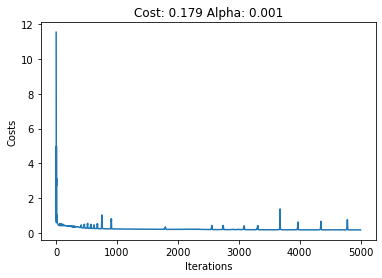

93.15


In [7]:
# test number 2: 
# - nepochs=5000; alpha=0.001; nH=(15,); hidden_g='relu'
# - this gives an accuracy of 0.93
# - with very quick convergence (# of iternations to hit minimum cost) and final cost of 0.18

np.random.seed(42) 
nepochs = 5000 
alpha = 0.001 

fcn = FullyConnectedNetwork(
    n0=n, nH=(15,), nL=1, 
    hidden_g='relu', output_g='logistic')
fcn.fit (X, Y, alpha=alpha, nepochs=nepochs)
Ypred = fcn.predict(X)

score = fcn.accuracy(Ypred, Y)
print(round(score,2))

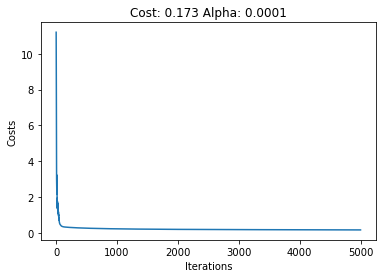

92.97


In [8]:
# test number 3:
# - nepochs=5000; alpha=0.0001; nH=(15,5); hidden_g='relu'
# - this gives an accuracy of 0.93
# - with very quick convergence (# of iternations to hit minimum cost) and final cost of 0.17

np.random.seed(42) 
nepochs = 5000 
alpha = 0.0001 

fcn = FullyConnectedNetwork(
    n0=n, nH=(15,5), nL=1, 
    hidden_g='relu', output_g='logistic')
fcn.fit (X, Y, alpha=alpha, nepochs=nepochs)
Ypred = fcn.predict(X)

score = fcn.accuracy(Ypred, Y)
print(round(score,2))